# The model

We will be implementing this architecture 

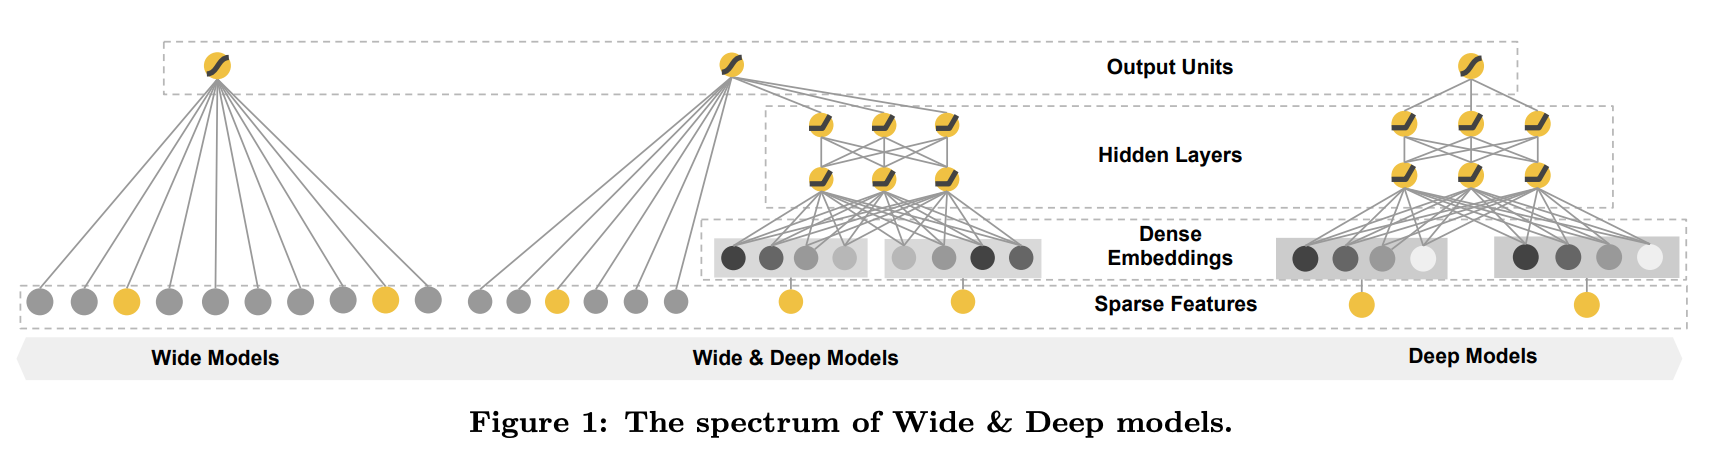

In [46]:
from IPython.display import Image
Image(filename = "figures/model_fig1.png", width=900, height=400)

This is Figure 1 in the original paper [Heng-Tze Cheng, et. al, 2016](https://arxiv.org/pdf/1606.07792.pdf).

Mathematically, the model can be formulated as: 

$$
P(Y = 1|x) = \sigma(W^{T}_{wide}[x, \phi(x)] + W^{T}_{deep}a^{(l_f)} + b)
$$

Where $Y$ is the binary class label (in their case they perform a logistic regression),  $\sigma(\cdot)$ is the activation function, in their case Sigmoid, $\phi(x)$ are the cross product transformations of the original features $x$, and $b$ is the bias term. $W_{wide}$ is the vector of all wide model weights, and $W_{deep}$ are the weights applied on the final activations $a^{(l_f)}$. 

At explained in the original paper: "*For binary features, a cross-product transformation (e.g., AND(gender=female, language=en)) is 1 if and only if the constituent features (gender=female and language=en) are all 1, and 0 otherwise*".

# PREPARE THE DATA

For this presentation I will be using the well known [adult dataset](https://www.kaggle.com/wenruliu/adult-income-dataset#adult.csv).

In [47]:
import pandas as pd
import numpy as np

columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
           "occupation" , "relationship", "race", "sex", "capital_gain", "capital_loss", 
           "hours_per_week", "native_country", "income"]

df_tr = pd.read_csv('data/adult_train.csv', names=columns)
df_te = pd.read_csv('data/adult_test.csv', names=columns)
df = pd.concat([df_tr, df_te])

In [48]:
print(df.shape)
df.head()

(48842, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [49]:
df.income.value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: income, dtype: int64

In [50]:
df['income_label'] = (df["income"].apply(lambda x: ">50K" in x)).astype(int)
df.drop('income', axis=1, inplace=True)
df.income_label.value_counts()
target = df.income_label.values

In [51]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# 1. Wide

The wide component is simply a linear model where the non-linearities are captured via crossed-products. The input of the wide component are one-hot encoded features. 

In [52]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income_label'],
      dtype='object')

In [53]:
wide_cols = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex',
             'native_country']
crossed_cols = (['education', 'occupation'], ['native_country', 'occupation'])

### 1.1 Crossed Columns

In [54]:
def cross_cols(df):
    crossed_colnames = []
    for cols in crossed_cols:
        cols = list(cols)
        for c in cols:
            df[c] = df[c].astype("str")
        colname = "_".join(cols)
        df[colname] = df[cols].apply(lambda x: "-".join(x), axis=1)
        crossed_colnames.append(colname)
    return df, crossed_colnames

In [55]:
df_wide = df.copy()[wide_cols]

In [56]:
df_wide, crossed_colnames = cross_cols(df)

In [57]:
print(crossed_colnames)
df_wide.head()

['education_occupation', 'native_country_occupation']


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_label,education_occupation,native_country_occupation
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,Bachelors- Adm-clerical,United-States- Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Bachelors- Exec-managerial,United-States- Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,HS-grad- Handlers-cleaners,United-States- Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,11th- Handlers-cleaners,United-States- Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Bachelors- Prof-specialty,Cuba- Prof-specialty


In [58]:
wide_crossed_cols = wide_cols + crossed_colnames

In [59]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(sparse=False)
X_wide = one_hot_enc.fit_transform(df_wide[wide_crossed_cols],)

In [60]:
X_wide.shape

(48842, 808)

# 2. Deep

As before, let's define the columns that will be passed through the deep component, i.e. represented as embeddings and then passed through a series of dense layers along with continuous columns.

In [61]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_label,education_occupation,native_country_occupation
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,Bachelors- Adm-clerical,United-States- Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Bachelors- Exec-managerial,United-States- Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,HS-grad- Handlers-cleaners,United-States- Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,11th- Handlers-cleaners,United-States- Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Bachelors- Prof-specialty,Cuba- Prof-specialty


In [62]:
emb_cols = ['workclass', 'education', 'occupation', 'relationship', 'native_country'] 
cont_cols= ['age', 'hours_per_week']
deep_cols = emb_cols + cont_cols
df_deep = df.copy()[deep_cols]

In [63]:
# Extract the categorical column names that will be label_encoded
categorical_columns = list(df_deep.select_dtypes(include=['object']).columns)
categorical_columns

['workclass', 'education', 'occupation', 'relationship', 'native_country']

Now we need to "label encode" these categorical features. to that aim I normally prefer to use my own function instead of sklearn's `LabelEncoder`. This is because I find accessing to the encoding dictionary a bit convoluted when using `LabelEncoder`.  

In [64]:
def label_encode(df_inp, cols=None, val_to_idx=None):
    df = df_inp.copy()

    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    if not val_to_idx:

        val_types = dict()
        for c in cols:
            val_types[c] = df[c].unique()

        val_to_idx = dict()
        for k, v in val_types.items():
            val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return df, val_to_idx

In [65]:
df_deep, encoding_dict = label_encode(df_deep, cols=categorical_columns)

In [66]:
df_deep.head()

,workclass,education,occupation,relationship,native_country,age,hours_per_week
0,0,0,0,0,0,39,40
1,1,0,1,1,0,50,13
2,2,1,2,0,0,38,40
3,2,2,2,1,0,53,40
4,2,0,3,2,1,28,40


In [67]:
encoding_dict

{'workclass': {' State-gov': 0,
  ' Self-emp-not-inc': 1,
  ' Private': 2,
  ' Federal-gov': 3,
  ' Local-gov': 4,
  ' ?': 5,
  ' Self-emp-inc': 6,
  ' Without-pay': 7,
  ' Never-worked': 8},
 'education': {' Bachelors': 0,
  ' HS-grad': 1,
  ' 11th': 2,
  ' Masters': 3,
  ' 9th': 4,
  ' Some-college': 5,
  ' Assoc-acdm': 6,
  ' Assoc-voc': 7,
  ' 7th-8th': 8,
  ' Doctorate': 9,
  ' Prof-school': 10,
  ' 5th-6th': 11,
  ' 10th': 12,
  ' 1st-4th': 13,
  ' Preschool': 14,
  ' 12th': 15},
 'occupation': {' Adm-clerical': 0,
  ' Exec-managerial': 1,
  ' Handlers-cleaners': 2,
  ' Prof-specialty': 3,
  ' Other-service': 4,
  ' Sales': 5,
  ' Craft-repair': 6,
  ' Transport-moving': 7,
  ' Farming-fishing': 8,
  ' Machine-op-inspct': 9,
  ' Tech-support': 10,
  ' ?': 11,
  ' Protective-serv': 12,
  ' Armed-Forces': 13,
  ' Priv-house-serv': 14},
 'relationship': {' Not-in-family': 0,
  ' Husband': 1,
  ' Wife': 2,
  ' Own-child': 3,
  ' Unmarried': 4,
  ' Other-relative': 5},
 'native_countr

In [68]:
emb_dim = {'workclass': 10, 'education': 10, 'occupation': 10, 'relationship': 10,  'native_country': 16}

In [69]:
embeddings_input = []
for k,v in encoding_dict.items():
    embeddings_input.append((k, len(v), emb_dim[k]))
deep_column_idx = {k:v for v,k in enumerate(df_deep.columns)}

In [70]:
embeddings_input

[('workclass', 9, 10),
 ('education', 16, 10),
 ('occupation', 15, 10),
 ('relationship', 6, 10),
 ('native_country', 42, 16)]

In [71]:
deep_column_idx

{'workclass': 0,
 'education': 1,
 'occupation': 2,
 'relationship': 3,
 'native_country': 4,
 'age': 5,
 'hours_per_week': 6}

and now let's scale the continuous columns

In [72]:
from sklearn.preprocessing import StandardScaler
standardize_cols = cont_cols
scaler = StandardScaler()
for cc in standardize_cols:
    df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1).astype(float))
df_deep.head()

,workclass,education,occupation,relationship,native_country,age,hours_per_week
0,0,0,0,0,0,0.025996,-0.034087
1,1,0,1,1,0,0.828308,-2.213032
2,2,1,2,0,0,-0.046942,-0.034087
3,2,2,2,1,0,1.047121,-0.034087
4,2,0,3,2,1,-0.776316,-0.034087


In [73]:
X_deep = df_deep.values

In [74]:
X_deep.shape

(48842, 7)

In [75]:
from sklearn.datasets.base import Bunch

wide_deep_data = Bunch(
    wide = X_wide.astype('float32'), 
    deep = X_deep, 
    target = target.astype('float32'),
    embed_input = embeddings_input,
    encoding_dict = encoding_dict,
    deep_column_idx = deep_column_idx,
    cont_cols = cont_cols
    )

In [76]:
import pickle
pickle.dump(wide_deep_data, open("data/wide_deep_data.p", "wb"))